### Import necessary library

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [20]:
image_path = "/content/orange.jpg"
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [21]:
def load_and_preprocess_image(image_path):
    img_raw = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return tf.expand_dims(img, axis=0)

In [22]:
image = load_and_preprocess_image(image_path)

In [23]:
model = tf.keras.applications.MobileNetV2(weights='imagenet')

In [24]:
def get_prediction_and_confidence(model, image):
    preds = model(image)
    decoded = tf.keras.applications.mobilenet_v2.decode_predictions(preds.numpy())[0][0]
    return decoded[1], decoded[2]

In [25]:
def create_adversarial_pattern(image, label_index):
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()(label_index, prediction)
    gradient = tape.gradient(loss, image)
    return tf.sign(gradient)

In [26]:
label_name, confidence = get_prediction_and_confidence(model, image)
print(f"Original prediction: {label_name} ({confidence:.2f})")


label_index = tf.constant([imagenet_labels.tolist().index(label_name)])

Original prediction: orange (0.97)


In [27]:
perturbation = create_adversarial_pattern(image, label_index)

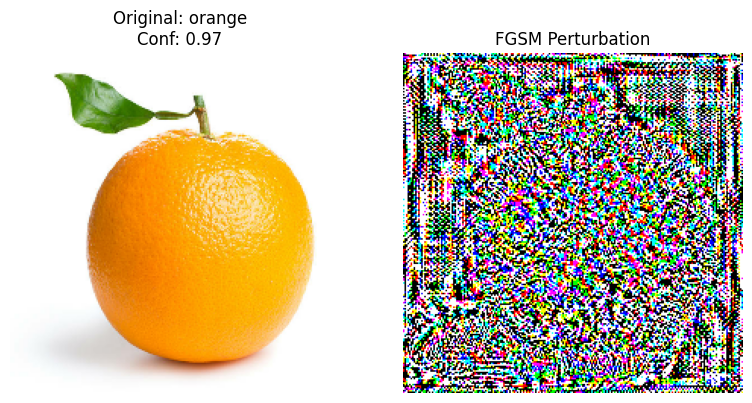

In [28]:
plt.figure(figsize=(8, 4))


plt.subplot(1, 2, 1)
plt.imshow(tf.keras.utils.array_to_img((image[0] + 1) / 2))
plt.title(f"Original: {label_name}\nConf: {confidence:.2f}")
plt.axis('off')


plt.subplot(1, 2, 2)
plt.imshow(tf.keras.utils.array_to_img((perturbation[0] + 1) / 2))
plt.title("FGSM Perturbation")
plt.axis('off')

plt.tight_layout()
plt.show()

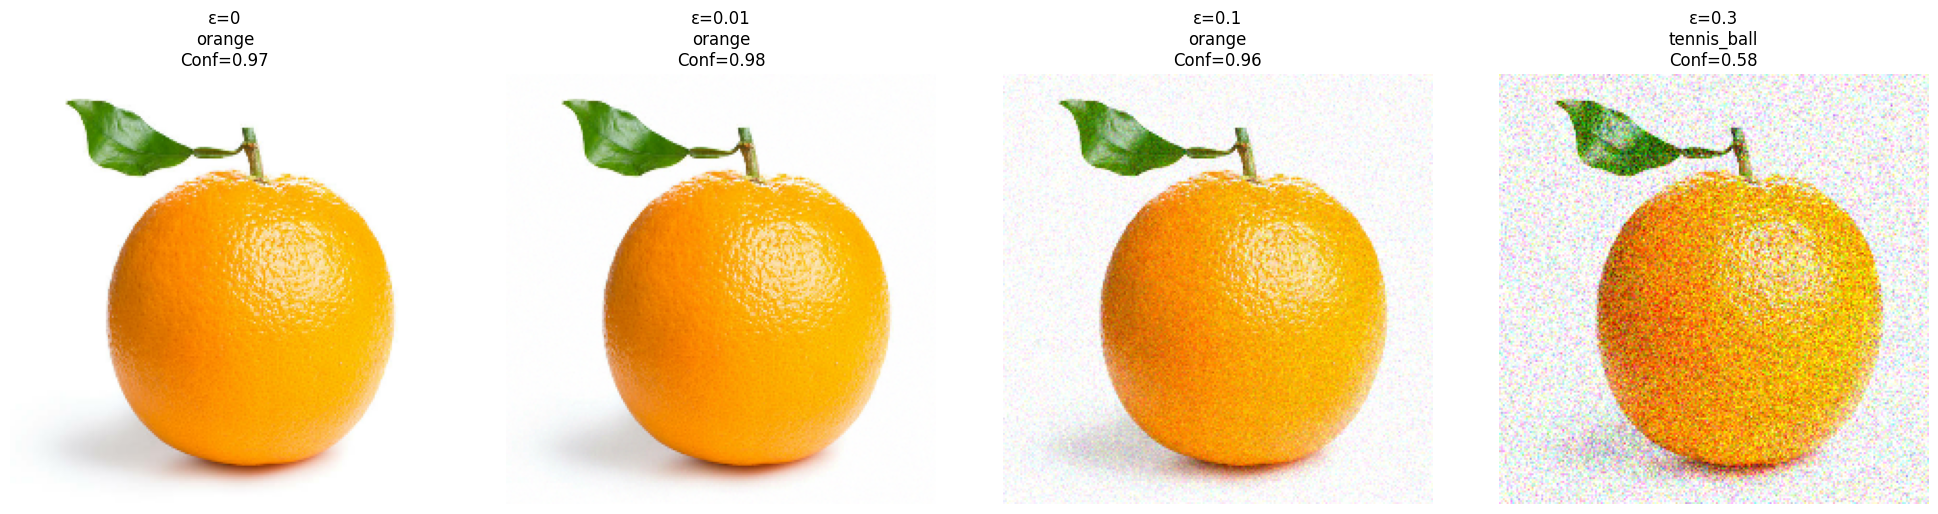

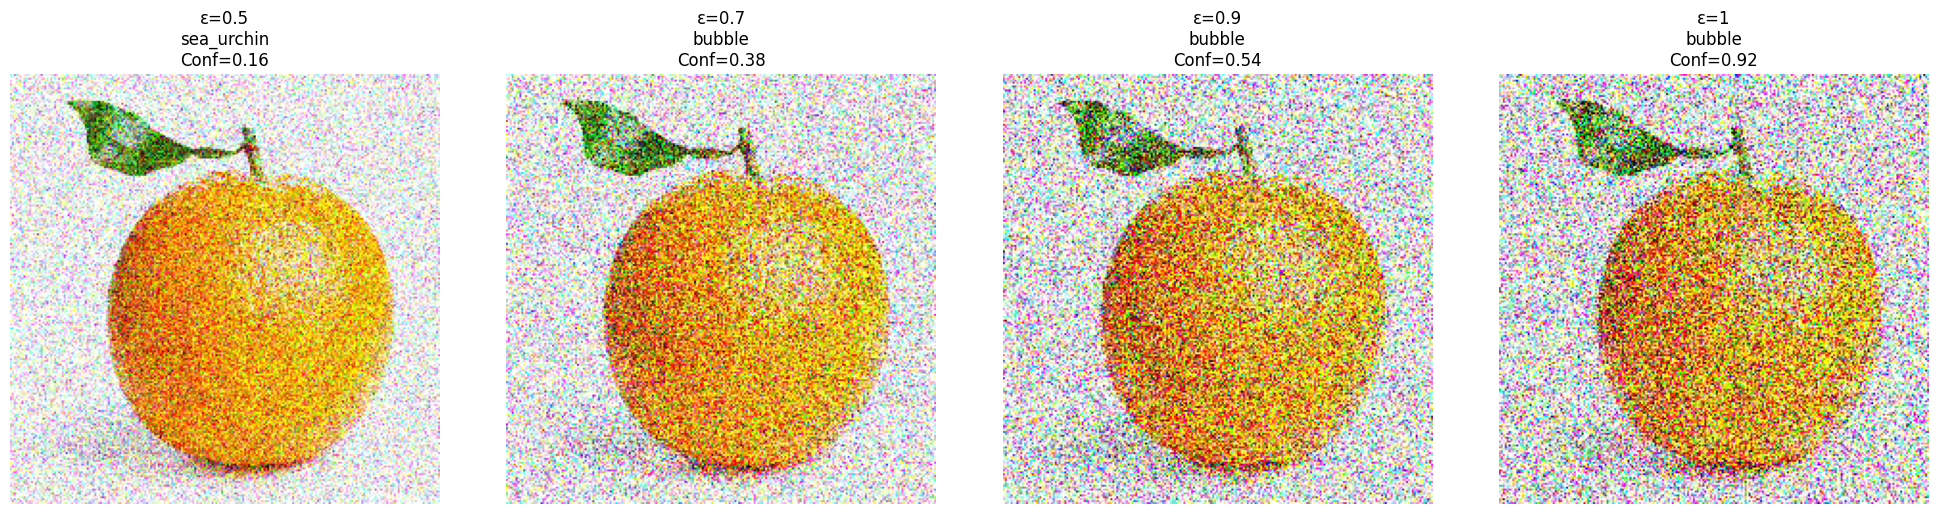

In [29]:
epsilons = [0, 0.01, 0.10, 0.30]
plt.figure(figsize=(20, 5))

for i, eps in enumerate(epsilons):
    noise = tf.random.normal(shape=image.shape, mean=0.0, stddev=1.0)
    noisy_image = tf.clip_by_value(image + eps * noise, -1.0, 1.0)

    label, conf = get_prediction_and_confidence(model, noisy_image)

    plt.subplot(1, 4, i + 1)
    plt.imshow(tf.keras.utils.array_to_img((noisy_image[0] + 1) / 2))
    plt.title(f"ε={eps}\n{label}\nConf={conf:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

epsilons = [0.50, 0.70, 0.90, 1]
plt.figure(figsize=(20, 5))

for i, eps in enumerate(epsilons):
    noise = tf.random.normal(shape=image.shape, mean=0.0, stddev=1.0)
    noisy_image = tf.clip_by_value(image + eps * noise, -1.0, 1.0)

    label, conf = get_prediction_and_confidence(model, noisy_image)

    plt.subplot(1, 4, i + 1)
    plt.imshow(tf.keras.utils.array_to_img((noisy_image[0] + 1) / 2))
    plt.title(f"ε={eps}\n{label}\nConf={conf:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()